In [2]:
import matplotlib.pyplot as plt
import zarr

from robotics.imitation_learning import episode_ends

In [ ]:
dataset = zarr.open("../data/demonstrations_snapshot_1.zarr", mode="r")

In [ ]:
data = dataset["data"]

In [ ]:
imgs = data["img"]

In [ ]:
imgs.shape

In [ ]:
imgs[0].shape

In [ ]:
img = imgs[340]

In [ ]:
plt.imshow(img/ 255)

In [ ]:
actions = data["action"][:]

In [ ]:
dataset["episode_ends"].shape

In [ ]:
actions.shape

In [ ]:
actions[0]

DataLoader

In [2]:
from torch.utils.data import Dataset
import torch

def normalize_data(data, scale):
    return data / scale

def denormalize_data(data, scale):
    return data * scale

class PushTDataset(Dataset):
    def __init__(self, data_path):
        dataset = zarr.open(data_path, mode="r") # action, img, keypoint, n_contacts, state

        image_data = dataset["data"]["img"][:] # ndarray [0-255], shape = (total, 96, 96, 3)

        self.image_data_transformed = normalize_data(image_data, 255) # ndarray [0-1], shape = (total, 3, 96, 96)

        actions_data = dataset["data"]["action"][:] # ndarray [0-512], shape = (total, 2)

        self.actions_data_transformed = normalize_data(actions_data, 512)

        self.episode_ends = dataset["episode_ends"][:]

    def __len__(self):
        return len(self.image_data_transformed)

    def __getitem__(self, idx):
        return torch.from_numpy(data["action"][idx]).float()


In [3]:
dataset = PushTDataset("../data/demonstrations_snapshot_1.zarr")

In [4]:
action, image = dataset.actions_data_transformed[33], dataset.image_data_transformed[33]

[418. 371.]


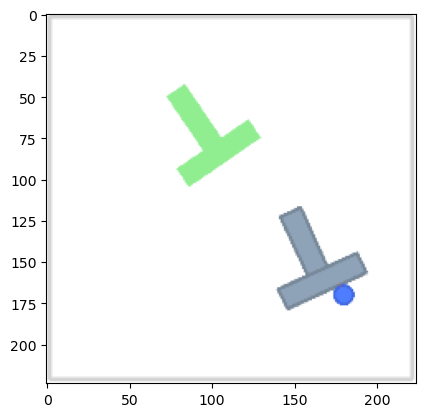

In [5]:
print(denormalize_data(action, scale=512))
plt.imshow(image)

### Correct sequence split

#### Data

* **actions**
  `[1,3,5,2,1,7,9,4,3,2]`
* **images**
  `[img1,img2,img3,img4,img5,img6,img7,img8,img9,img10]`

#### Proper `episode_ends` array

The recording code appends **cumulative** episode lengths.
With three episodes of lengths

* episode1=4 steps
* episode2=4 steps
* episode3=2 steps

we get:

```python
episode_ends = [0, 4, 8, 10]
```

#### Split

| Episode | Slice in the array | actions     | images                 |
| ------- | ------------ | ----------- | ---------------------- |
| 1       | `0:4`        | `[1,3,5,2]` | `[img1,img2,img3,img4]` |
| 2       | `4:8`        | `[1,7,9,4]` | `[img5,img6,img7,img8]` |
| 3       | `8:10`       | `[3,2]`     | `[img9,img10]`         |


In [14]:
import random


def generate_sample_dataset(n):
    actions = []
    images = []
    step_in_episode = 0
    episode_ends = [0]

    action = 0
    counter = 0

    for _ in range(n):
        action += 1
        counter += 1

        images.append(f"img{counter}")
        actions.append(action)

        step_in_episode += 1

        if random.random() > 0.8:
            episode_ends.append(episode_ends[-1] + step_in_episode)
            step_in_episode = 0
            action = 0

    return images, actions, episode_ends

In [15]:
images, actions, episode_ends = generate_sample_dataset(20)

In [16]:
actions

[1, 2, 3, 1, 2, 3, 4, 1, 2, 3, 1, 1, 2, 3, 4, 5, 6, 1, 2, 3]

In [17]:
episode_ends

[0, 3, 7, 10, 11, 17]

In [30]:
def create_trajectory_indices(episode_ends, horizon_left, horizon_right):
    """
    The method to precompute all possible windows that will be used in training process. When the left/right horizon is outside the one episode, it is padded with the most left/right index.

    Args:
        episode_ends_array:
        horizon_left:
        horizon_right:

    Returns:

    """
    def add_to_window(input_array, prediction_array, item, cur_item, input_limit):
        if cur_item <= input_limit:
            input_array.append(item)
        else:
            prediction_array.append(item)


    windows = []
    start_idx = 0
    input_lim_idx = horizon_left + 1
    for i in range(len(episode_ends) - 1):
        end_idx = episode_ends[i + 1]
        if i > 0:
            start_idx = episode_ends[i] + 1

        print("seq: ", start_idx, end_idx)

        for cur_idx in range(start_idx, end_idx):
            input = []
            prediction = []
            counter = 0
            for displace in range(-horizon_left, horizon_right - horizon_left + 2):
                if cur_idx + displace < start_idx:
                    # input.append(start_idx)
                    idx_at_position = start_idx
                elif cur_idx + displace > end_idx:
                    # prediction.append(end_idx)
                    idx_at_position = end_idx
                else:
                    idx_at_position = cur_idx + displace
                    # prediction.append(cur_idx + displace)

                counter += 1
                add_to_window(input, prediction, idx_at_position, counter, input_lim_idx)

            windows.append((input, prediction))

    return windows

wind = create_trajectory_indices(episode_ends, horizon_left=1, horizon_right=2)

seq:  0 3
seq:  4 7
seq:  8 10
seq:  11 11
seq:  12 17
